## Calculate wet bulb temperature
Approaches to calculate wet bulb temperature are discussed in [Knox et al. (2017)](https://journals.ametsoc.org/bams/article/98/9/1897/70218/Two-Simple-and-Accurate-Approximations-for-Wet).

In [35]:
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt
from metpy import calc as mpcalc
from metpy.units import units as mpunits
from numba import jit

In [36]:
### Iterative formula originally from NWS website : https://www.weather.gov/epz/wxcalc_dewpoint
### and written in python here: https://github.com/Unidata/MetPy/issues/1006#issuecomment-464409522

def esubx(temp):
    e_x = 6.112 * np.exp((17.67 * temp) / (temp + 243.5))

    return e_x

@jit(nopython=True)
def wet_bulb_temperature_point(tw_guess,
                  temp_c,
                  pressure_mb):

#     e = esubx(tw_guess)
    e = 6.112 * np.exp((17.67 * tw_guess) / (tw_guess + 243.5))
    increment = 10
    e_diff = 1
    prev_sign = 1

    while abs(e_diff) > 0.05:
        e_w_guess = 6.112 * np.exp((17.67 * tw_guess) / (tw_guess + 243.5))
        e_guess = e_w_guess - pressure_mb * (temp_c - tw_guess) * 0.00066 * (1 + (0.00115 * tw_guess))
        e_diff = e - e_guess

        if e_diff == 0:
            break
        else:
            if e_diff < 0:
                cursign = -1
                if cursign != prev_sign:
                    prev_sign = cursign
                    increment = increment/10
                else:
                    increment = increment
            else:
                cursign = 1
                if cursign != prev_sign:
                    prev_sign = cursign
                    increment = increment/10
                else:
                    increment = increment
        if abs(e_diff) <= 0.05:
            break
        else:
            tw_guess = tw_guess + increment * prev_sign
            
    wetbulb = tw_guess

    return wetbulb

## Some other functions from here: https://anaconda.org/ahuang11/wet_bulb_temperature/notebook

def stull_wtb(tmp, rlh):
    # https://journals.ametsoc.org/doi/full/10.1175/JAMC-D-11-0143.1
    term1_stull = tmp * np.arctan(0.151977 * np.sqrt(rlh + 8.313659))
    term2_stull = np.arctan(tmp + rlh)
    term3_stull = np.arctan(rlh - 1.676331)
    term4_stull = 0.00391838 * np.power(rlh, 1.5) * np.arctan(0.023101 * rlh)
    term5_stull = 4.686035
    return term1_stull + term2_stull - term3_stull + term4_stull - term5_stull

def half_wtb(tmp, dpt):
    # https://journals.ametsoc.org/doi/10.1175/BAMS-D-16-0246.1
    return 0.5 * (tmp + dpt)

def third_wtb(tmp, dpt):
    # https://journals.ametsoc.org/doi/10.1175/BAMS-D-16-0246.1
    return 2 / 3 * tmp + 1 / 3 * dpt


In [37]:
@jit(nopython=True)
def wet_bulb_temperature(tw_guess,temp_c,pressure_mb):
    ni,nj,nt = tw_guess.shape
    twb = np.empty(shape=(ni,nj,nt))
    for i in range(ni):
        for j in range(nj):
            for t in range(nt):
                twb[i,j,t] = wet_bulb_temperature_point(tw_guess[i,j,t],temp_c[i,j,t],pressure_mb[i,j,t])
    return twb

In [60]:
def mpcalc_wet_bulb_temperature_from_specific_humidity(specific_humidity, temperature, pressure):
    qvr = specific_humidity/(1-specific_humidity)
    e = mpcalc.vapor_pressure(pressure,qvr*mpunits('kg/kg'))
    td = mpcalc.dewpoint(e)
    twb = mpcalc.wet_bulb_temperature(pressure,temperature,td)
    return twb

In [61]:
# Point to model data
rootdir = '/local/projects/GFDL_LEs/ATM/RCP85/'
suffix = '.rcp85.ens101.1950_1959.nc'
variables = ['sphum_k24','t_ref']
ds = xr.Dataset()
for var in variables:
    print(var)
    ds[var] = xr.open_dataarray(rootdir+var+suffix).squeeze()
# Load pressure (time variable is slightly off in raw data)
var = 'ps'
print(var)
ps = xr.open_dataarray(rootdir+var+suffix).squeeze()
tmin = ds['sphum_k24']['time'].min('time').values
tmax = ds['sphum_k24']['time'].max('time').values
ds['ps'] = ps.sel(time=slice(tmin,tmax))
# drop the pfull variable
ds = ds.drop('pfull')

sphum_k24
t_ref
ps


In [121]:
# Specify temperature, pressure and specific humidity
ni = ds.sizes['lon']
nj = ds.sizes['lat']
nt = ds.sizes['time']
lons = np.array([55,56])#np.arange(0,ni)
lats = np.array([35,36])#np.arange(0,nj)
times = np.arange(0,100)
temp_c = ds['t_ref'].transpose('lon','lat','time')[lons,lats,times].values-273.15
pressure_mb = ds['ps'].transpose('lon','lat','time')[lons,lats,times].values/100
sphum = ds['sphum_k24'].transpose('lon','lat','time')[lons,lats,times].values

In [122]:
# Take a first guess at a temperature, starting from the dewpoint
mixing_ratio = sphum/(1-sphum)
e = mpcalc.vapor_pressure(pressure_mb*mpunits('mbar'),mixing_ratio*mpunits('kg/kg'))
dewpoint = mpcalc.dewpoint(e).magnitude
relative_humidity = mpcalc.relative_humidity_from_specific_humidity(sphum, temp_c*mpunits('degC'), pressure_mb*mpunits('mbar')).magnitude
# Take a first guess at the wet bulb temperature
# tw_guess = stull_wtb(temp_c,relative_humidity)
tw_guess = third_wtb(temp_c, dewpoint)

In [123]:
twb_metpy = mpcalc.wet_bulb_temperature(pressure_mb.squeeze()*mpunits('mbar'),temp_c.squeeze()*mpunits('degC'), dewpoint.squeeze()*mpunits('degC'))
twb_metpy.shape

(2, 2, 100)

In [124]:
twb = wet_bulb_temperature(tw_guess,temp_c,pressure_mb).squeeze()
twb.shape

(2, 2, 100)

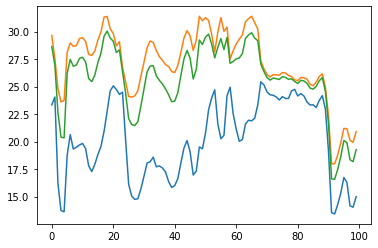

In [131]:
plt.plot(twb_metpy[0,0,:].magnitude)
plt.plot(twb[0,0,:])
plt.plot(tw_guess[0,0,:])

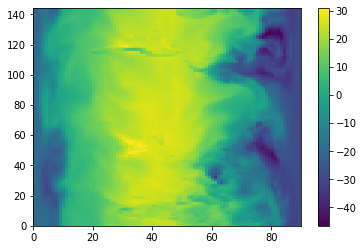

In [106]:
im = plt.pcolormesh(twb)
plt.colorbar(im)

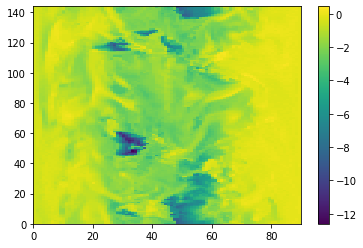

In [107]:
im = plt.pcolormesh((twb_metpy.magnitude-twb))
plt.colorbar(im)